# Here we show how to apply acceptance functions to the spacial muon distribution

In [1]:
import sys
import numpy as np
import pandas as pd

basedir='/Users/bono/Desktop/gm2FieldAnalysis/MuonConvolution/'

#import the relevant field moments functions
path = basedir + 'field_info'
sys.path.insert(0,path)
from format_field import field_team_to_standard_moments as ftts
from field_grid import *

#import the relevant synthesis tools
path = basedir + 'synthesis'
sys.path.insert(0,path)
from spacial_tools import moments_method as mm
from basic_grid_tools import *

path= basedir + 'tracker_info'
sys.path.append(path)
from beam_moments import *
from transform_beam import *
from beam_moments import get_normalized_distribution_moments as gndm


### Get the tracker distribution for station 12

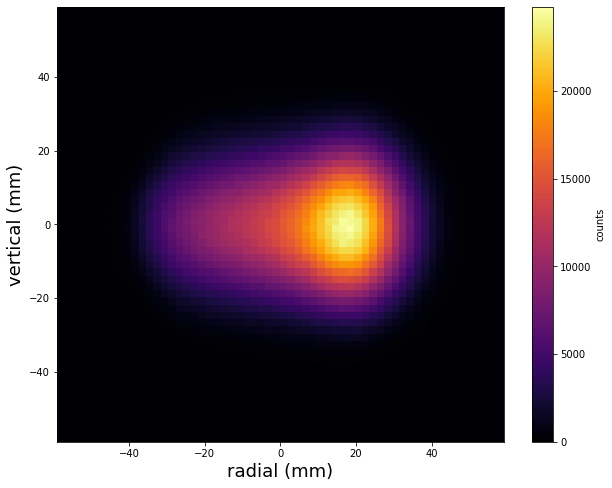

In [2]:
df_tracker = get_df_tracker()
mask12 = (df_tracker["Station"] == 'station12')
df_12 = df_tracker[mask12].copy()
df_12['counts_norm'] = df_12['counts']/df_12['counts'].sum()
df_12.head()
fig = plot_beam(df_12,bins=60)
fig

### invent some acceptance function

1576.0


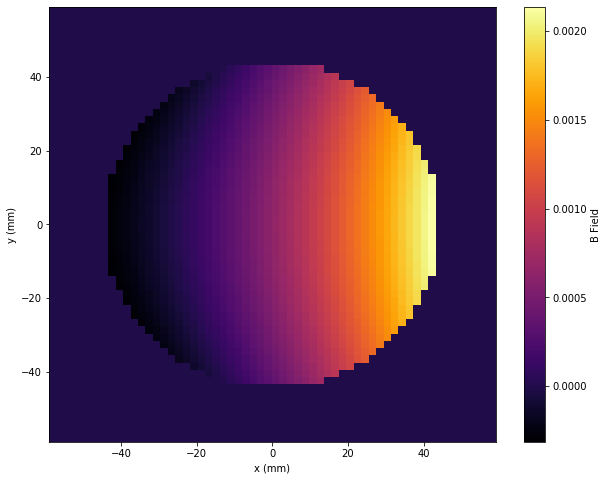

In [3]:
#generate
acc = [1,2,0,0.5,0]
#make the df representing the grid with appropriate col names
df_acc = get_field_grid(acc)
df_acc.rename(columns={"B": "acc"},inplace=True)
#make all values outside of the storage volume zero
mask = (df_acc['x']**2 + df_acc['y']**2 > 45**2)
df_acc.loc[mask,'acc'] = 0
#normalize
N = df_acc['acc'].sum()
print(N)
df_acc['acc'] = df_acc['acc']/N
df_acc
fig = plot_field(df_acc,var='acc')
fig

### Take the hadamard product of the acceptance and beam functions

In [4]:
df_12['counts_acc'] = df_12['counts']*df_acc['acc']

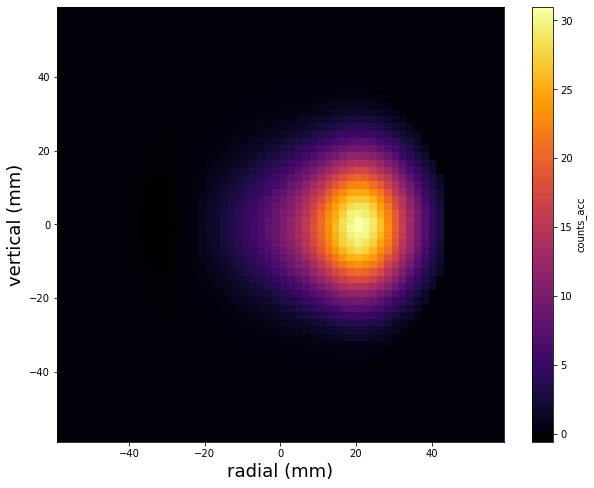

In [5]:
fig = plot_beam(df_12,var='counts_acc')
fig

# Now get a real acceptance function

In [6]:
def get_df_acc_raw(file = "/Users/bono/Desktop/gm2FieldAnalysis/MuonConvolution/acceptance_functions/data/PositronAcceptance.txt"):
    names=['x', 'y', 'acc']
    df = pd.read_csv(file, sep=",",names=names,skiprows=1)
    
    #convert values to numeric
    df["acc"] = df["acc"].astype('float')
    df["x"] = df["x"].astype('float')
    df["y"] = df["y"].astype('float')
    
    df.set_index(['x', 'y'],inplace=True)    
    
    return df

In [7]:
df_raw = get_df_acc_raw()
df_raw.reset_index(inplace=True)
df_raw.head()

,x,y,acc
0,-42.5,-12.5,70.935203
1,-42.5,-7.5,71.152978
2,-42.5,-2.5,70.914991
3,-42.5,2.5,71.147157
4,-42.5,7.5,71.081039


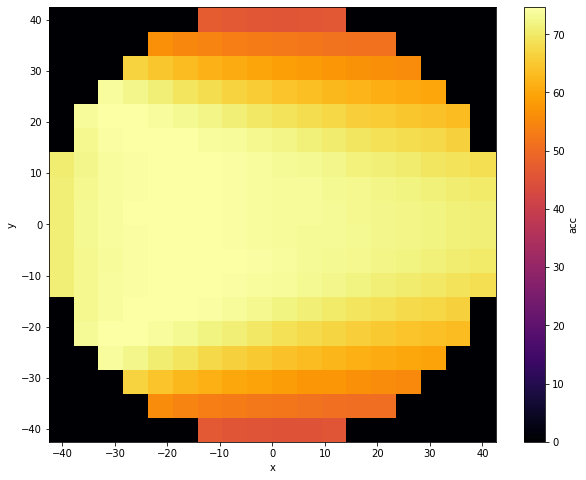

In [8]:
plot_grid(df=df_raw,zvar='acc')

In [9]:
df_acc_real = rebin_df(df_raw,edge=59,step=2,zvar='acc')

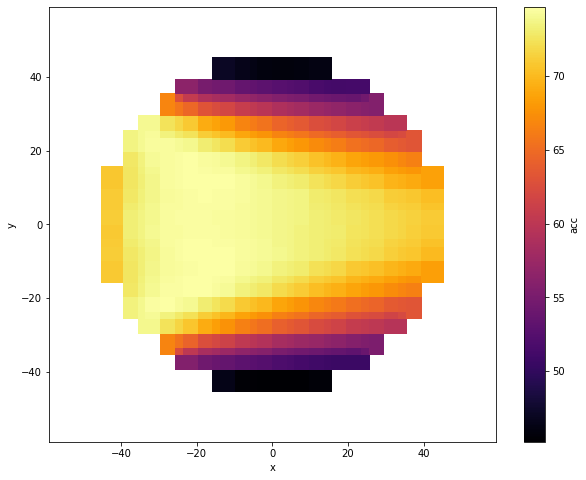

In [10]:
plot_grid(df=df_acc_real,zvar='acc')

In [11]:
df_12['counts_acc_real'] = df_12['counts']*df_acc_real['acc']

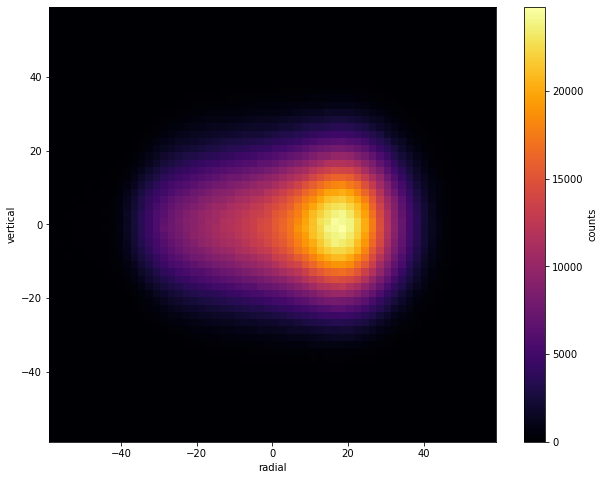

In [12]:
plot_grid(df=df_12,xvar='radial',yvar='vertical',zvar='counts')

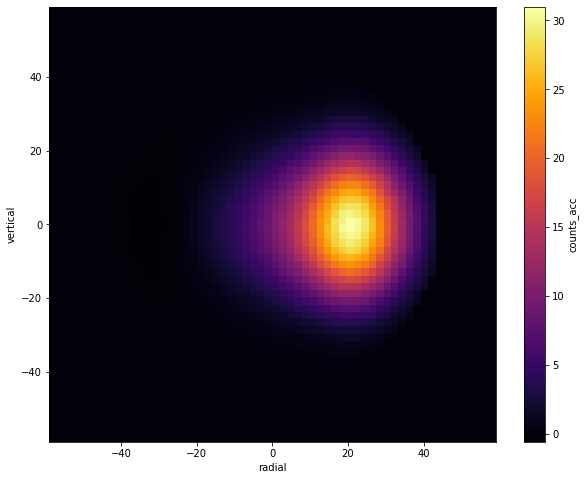

In [13]:
plot_grid(df=df_12,xvar='radial',yvar='vertical',zvar='counts_acc')

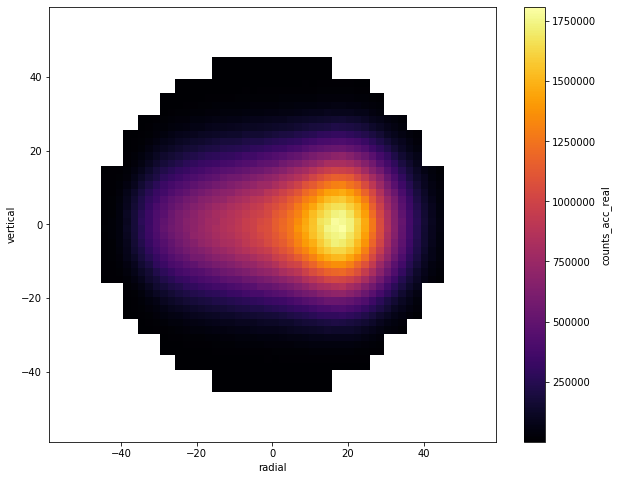

In [14]:
plot_grid(df=df_12,xvar='radial',yvar='vertical',zvar='counts_acc_real')

# Calculate the beam moments 

## first get the nominal field

In [15]:
path = basedir + 'synthesis/data/60H_field_ctag_dqm.pkl'
df = pd.read_pickle(path)
total_ctags = df["ctags"].sum()
b = [
    (df["D"]*df["ctags"]).sum()/total_ctags,
    (df["NQ"]*df["ctags"]).sum()/total_ctags,
    (df["SQ"]*df["ctags"]).sum()/total_ctags,
    (df["NS"]*df["ctags"]).sum()/total_ctags
    ]
c,s = ftts(b)

In [16]:
x = df_12['radial']
y = df_12['vertical']
weights = df_12['counts']
weights_acc = df_12['counts_acc_real']
N = 3

In [17]:
I_norm, J_norm = gndm(N,x,y,weights)
print('--with acc--','\n')
print(I_norm,'\n')
print(J_norm,'\n')
print(c*I_norm,'\n')
print(s*J_norm,'\n')
moments_result = mm(c,s,I_norm,J_norm)
print('total = ', moments_result)

--with acc-- 

[1.         0.15097058 0.10640059] 

[ 0.         -0.00012891  0.00056273] 

[ 8.41413353e+02 -1.43185781e-03 -1.26000550e-01] 

[ 0.00000000e+00 -3.00142634e-05  0.00000000e+00] 

total =  841.2858909405439


In [18]:
I_norm_acc, J_norm_acc = gndm(N,x,y,weights_acc)
print('--with acc--','\n')
print(I_norm_acc,'\n')
print(J_norm_acc,'\n')
print(c*I_norm_acc,'\n')
print(s*J_norm_acc,'\n')
moments_result_acc = mm(c,s,I_norm_acc,J_norm_acc)
print('total = ', moments_result_acc)

--with acc-- 

[1.         0.14296741 0.10526976] 

[ 0.         -0.00051589  0.00011365] 

[ 8.41413353e+02 -1.35595291e-03 -1.24661404e-01] 

[ 0.         -0.00012012  0.        ] 

total =  841.2872158869054


In [19]:
print('--differences--','\n')
print(I_norm_acc - I_norm,'\n')
print(J_norm_acc - J_norm,'\n')
print(c*(I_norm_acc - I_norm),'\n')
print(s*(J_norm_acc - J_norm),'\n')

print(moments_result_acc - moments_result)

--differences-- 

[ 0.         -0.00800317 -0.00113084] 

[ 0.         -0.00038699 -0.00044907] 

[0.00000000e+00 7.59048975e-05 1.33914637e-03] 

[ 0.00000000e+00 -9.01049028e-05 -0.00000000e+00] 

0.0013249463614783963


# Old scrap is below. can just ignore

,x,y,acc
0,-42.5,-12.5,70.935203
1,-42.5,-7.5,71.152978
2,-42.5,-2.5,70.914991
3,-42.5,2.5,71.147157
4,-42.5,7.5,71.081039


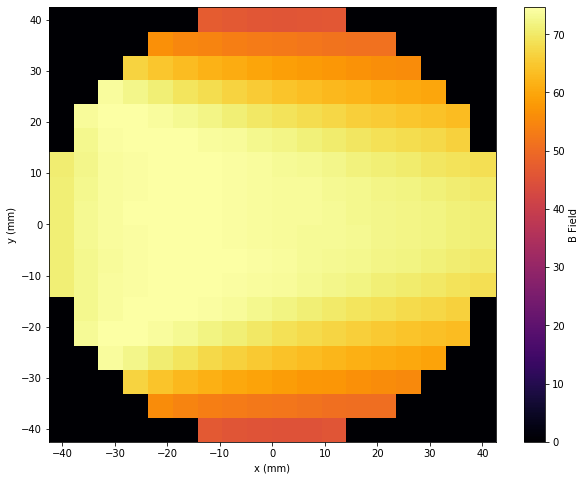

In [362]:
def plot_acc(df,bins=60,var='B'):
    fig = plt.figure(figsize=(10, 8))
    plt.hist2d(df['x'], df['y'], weights=df[var], bins=bins,cmap='inferno')
    plt.xlabel('x (mm)')
    plt.ylabel('y (mm)')
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('B Field')
    plt.close()
    return fig
plot_acc(df=df_raw,bins=18,var='acc')

In [363]:
def make_blank_df(edge=59,step=0.5):

    #get the values of x,y, and B for every point on the grid
    pos = np.arange(-edge,edge+1,step)
    vals = [(x,y) for x in pos for y in pos]
    vals = np.array(vals)

    #now make a pandas df and fill it with the grid values
    col_names =  ['x', 'y']
    df  = pd.DataFrame(columns = col_names)
    df['x'] = vals[:,0]
    df['y'] = vals[:,1]
    
    df["x"] = df["x"].astype('float')
    df["y"] = df["y"].astype('float')
    
    df.set_index(['x', 'y'],inplace=True)
    
    return df
df_blank = make_blank_df()
df_blank.reset_index(inplace=True)
df_blank.head()


,x,y
0,-59.0,-59.0
1,-59.0,-58.5
2,-59.0,-58.0
3,-59.0,-57.5
4,-59.0,-57.0


In [364]:
#do an outter join
df_new = pd.merge(df_raw, df_blank, on=['x','y'], how='outer')
df_new.sort_values(by=['x','y'],inplace=True)
mask = df_new['x'] == -42.5
df_new.head()

,x,y,acc
256,-59.0,-59.0,NaN
257,-59.0,-58.5,NaN
258,-59.0,-58.0,NaN
259,-59.0,-57.5,NaN
260,-59.0,-57.0,NaN


In [365]:
#forwardfill and backfill
df_new.fillna(method='ffill',inplace=True)
df_new.fillna(method='bfill',inplace=True)

In [366]:
#do an inner join
df_blank = make_blank_df(step=2)
df_blank.reset_index(inplace=True)
df_final = pd.merge(df_new, df_blank, on=['x','y'], how='inner')
df_final.head()

,x,y,acc
0,-59.0,-59.0,70.935203
1,-59.0,-57.0,70.935203
2,-59.0,-55.0,70.935203
3,-59.0,-53.0,70.935203
4,-59.0,-51.0,70.935203


In [367]:
#make things zero
mask = df_final['x']**2 + df_new['y']**2 > 45**2
df_final.loc[mask,'acc'] = 0

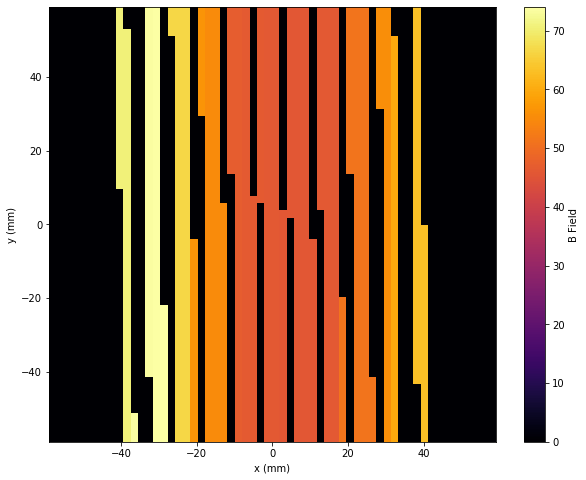

In [368]:
fig = plot_field(df_final,var='acc')
fig

In [353]:
def value(df,x,y):
    
    #if x is beyond the df range, return 0
    if( (x > df['x'].max()) or (x < df['x'].min()) ):
         return 0
    
    #if x is within the df range, find the closest corresponding value
    min_dist = abs(df['x'] - x).min()
    if (x > ) 
    
    return val
    
value(df_raw.reset_index(),3,0)

SyntaxError: invalid syntax (<ipython-input-353-90fd601ec206>, line 9)

In [354]:
df_acc_raw = get_df_acc_raw()
rng = np.arange(-59,60,0.5)
# df_acc_raw.reset_index(inplace=True)
# df_acc_raw.set_index('x',inplace=True)
# df_acc_raw = df_acc_raw.reindex(rng,level='x')
# df_acc_raw.reset_index(inplace=True)
# df_acc_raw.fillna(method='bfill',inplace=True)

# rng = np.arange(-59,60,2)
# df_acc_raw.set_index(['x', 'y'],inplace=True)
# df_acc_raw = df_acc_raw.reindex([rng,rng])
df_acc_raw

# df_acc_raw[100:]
# mask = (df_acc_raw['x'] < 3) & (df_acc_raw['x'] > -3)
# df_acc_raw[mask]
# def acc_val(df_acc_raw,x,y):
    

acc
x     y               
-42.5 -12.5  70.935203
      -7.5   71.152978
      -2.5   70.914991
       2.5   71.147157
       7.5   71.081039
...                ...
 42.5 -7.5   70.058131
      -2.5   70.914807
       2.5   71.032538
       7.5   70.218149
       12.5  68.512458

[256 rows x 1 columns]

In [326]:
def get_df_acc(df_acc_raw):
    #get the values of x,y, and B for every point on the grid
    pos = range(-59,60,2)
    vals = [(x,y,acc_val(df_acc_raw,x,y)) for x in pos for y in pos]
    vals = np.array(vals)

    #now make a pandas df and fill it with the grid values
    col_names =  ['x', 'y', var]
    df  = pd.DataFrame(columns = col_names)
    df['x'] = vals[:,0]
    df['y'] = vals[:,1]
    df[var] = vals[:,2]
    
    return df

In [327]:
df_acc = get_df_acc_simple()
df_acc_new

df_acc
# fig = plot_field(df_acc,var='acc',bins=16)
# fig

NameError: name 'df_acc_new' is not defined

In [305]:
df_12

,index,radial,vertical,counts,Station,counts_norm,counts_acc
0,2,-59.0,-59.0,0.0,station12,0.000000e+00,0.0
1,3,-59.0,-57.0,0.0,station12,0.000000e+00,0.0
2,4,-59.0,-55.0,0.0,station12,0.000000e+00,0.0
3,5,-59.0,-53.0,0.0,station12,0.000000e+00,0.0
4,6,-59.0,-51.0,0.0,station12,0.000000e+00,0.0
5,7,-59.0,-49.0,16.0,station12,1.813781e-06,0.0
6,8,-59.0,-47.0,10.0,station12,1.133613e-06,0.0
7,9,-59.0,-45.0,2.0,station12,2.267226e-07,0.0
8,10,-59.0,-43.0,6.0,station12,6.801679e-07,0.0
9,11,-59.0,-41.0,3.0,station12,3.400840e-07,0.0
